Autoencoders
======

In [51]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
gi_data = pd.read_csv("/content/drive/MyDrive/GI_Project/gi_data.csv", delimiter="\t")

In [22]:
foodData = pd.read_csv(f"/content/drive/MyDrive/GI_Project/USDA_Nutrition_DataV2.csv")
# Drop all columns with 50% or more NaN values
foodData = foodData.dropna(thresh=foodData.shape[0]*0.5, axis=1)
# Drop all rows without at least 90% non NaN data
foodData = foodData.dropna(thresh=foodData.shape[1]*0.8, axis=0)
foodData.shape

(344279, 15)

In [23]:
# Missing value imputation by average. IDK if this is the best way

# for column in foodData.columns[:]:
#     foodData[column] = foodData[column].fillna(foodData[column].mean())
# foodData

foodData = foodData.fillna(0)
foodData

,name,fdc_id,Protein [G],Total lipid (fat) [G],"Carbohydrate, by difference [G]",Energy [KCAL],"Fiber, total dietary [G]","Calcium, Ca [MG]","Iron, Fe [MG]","Sodium, Na [MG]","Vitamin C, total ascorbic acid [MG]",Cholesterol [MG],"Fatty acids, total trans [G]","Fatty acids, total saturated [G]","Sugars, total including NLEA [G]"
0,Tutturosso Green 14.5oz. NSA Italian Diced Tom...,344604,0.81,0.41,4.07,24.0,0.8,13.0,0.00,203.0,0.0,0.0,0.0,0.00,2.44
1,Tutturosso Green 14.5oz. Italian Diced Tomatoes,344605,0.81,0.41,4.07,24.0,0.8,16.0,0.00,203.0,0.0,0.0,0.0,0.00,2.44
2,KELLOGG APPLE JACKS .9OZ 100CT,344646,5.20,3.70,87.80,370.0,10.9,16.0,16.10,522.0,54.0,0.0,0.0,1.90,35.90
3,Carr's Crackers Pepper 4.25oz,344737,7.14,7.14,71.43,0.0,7.1,0.0,0.00,571.0,0.0,0.0,0.0,0.00,0.00
4,GARDENBURGER GB VEGGIE BURGERS BLACK BEAN 3OZ ...,344922,10.80,3.00,16.90,112.0,7.4,59.0,2.70,761.0,0.0,0.0,0.1,0.30,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407158,Bush's Organic Dark Red Kidney Beans 15 oz,2512365,6.28,0.23,17.09,94.0,4.2,59.0,1.87,77.0,0.0,0.0,0.0,0.04,0.59
407159,CAVENDISH FARMS POTATO PATTIES 6 x 5 LB,2512366,1.00,6.00,15.00,120.0,1.0,7.0,0.30,180.0,0.0,0.0,0.0,0.00,0.00
407160,Peterson Farms Treats Applesauce,2512368,0.00,0.00,10.94,39.0,0.8,4.0,0.00,0.0,21.1,0.0,0.0,0.00,9.38
407161,"Zee Zees Applesauce Cup, Cinnamon, Unsweetened...",2512369,0.00,0.00,10.94,39.0,0.8,5.0,0.00,0.0,46.9,0.0,0.0,0.00,9.38


In [24]:
X = foodData.iloc[:,2:]
labels = foodData['fdc_id']
num_features = X.shape[1]


# scaler = StandardScaler()
# scaler.fit(X)
# X = scaler.transform(X)

normalizer = preprocessing.Normalizer()
X = normalizer.fit_transform(X)



# Run this cell to train with GI data

In [36]:
gi_data = pd.read_csv("/content/drive/MyDrive/GI_Project/gi_data.csv", delimiter="\t")
foodData = pd.read_csv(f"/content/drive/MyDrive/GI_Project/NutritionDataUsdaGiMatched.csv")
foodData['GI'] = gi_data['GI']
# Drop all columns with 50% or more NaN values
foodData = foodData.dropna(thresh=foodData.shape[0]*0.5, axis=1)
# Drop all rows without at least 90% non NaN data
foodData = foodData.dropna(thresh=foodData.shape[1]*0.9, axis=0)
for column in foodData.columns[4:]:
    foodData[column] = foodData[column].fillna(0)#foodData[column].mean())

X = foodData.drop(columns=['gi_name', 'usda_name', 'score', 'fdc_id', 'GI'])
labels = foodData['GI'].astype(np.float32).to_numpy()
num_features = X.shape[1]


# scaler = StandardScaler()
# scaler.fit(X)
# X = scaler.transform(X)

normalizer = preprocessing.Normalizer()
X = normalizer.fit_transform(X)



Parameter Settings
-------------------


In [37]:
latent_dims = 5
num_epochs = 200
batch_size = 128
capacity = 64
learning_rate = 1e-3
use_gpu = True

In [38]:
class NutritionDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x_train=torch.tensor(x, dtype=torch.float32)
        self.y_train=torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

In [39]:
nutritionDataset = NutritionDataset(X, labels)

num_train = len(nutritionDataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_bs = 60
test_bs = 50

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

test_sampler = SubsetRandomSampler(valid_idx)

# Create Data loaders which we will use to extract minibatches of data to input to the network for training
train_loader = torch.utils.data.DataLoader(nutritionDataset, batch_size=train_bs,
    sampler=train_sampler, drop_last=False)
test_loader = torch.utils.data.DataLoader(nutritionDataset, batch_size=test_bs,
    drop_last=False)


In [46]:
class Encoder(nn.Module):
    def __init__(self, num_features):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(in_features=num_features, out_features=32)
        self.linear2 = nn.Linear(in_features=32, out_features=16)
        self.linear3 = nn.Linear(in_features=16, out_features=12)
        self.linear4 = nn.Linear(in_features=12, out_features=8)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        return x

class Decoder(nn.Module):
    def __init__(self, num_features):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(in_features=8, out_features=)
        self.linear2 = nn.Linear(in_features=4, out_features=8)
        self.linear3 = nn.Linear(in_features=8, out_features=12)
        self.linear4 = nn.Linear(in_features=12, out_features=num_features)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = torch.sigmoid(self.linear4(x))
        return x


class Autoencoder(nn.Module):
    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(num_features)
        self.decoder = Decoder(num_features)

    def forward(self, x, labels):

        latent = self.encoder(x)
        correlation = self.correlation(latent, labels)
        x_recon = self.decoder(latent)
        return x_recon, correlation

    def correlation(self, x, y):
        vx1 = x[:,0:1] - torch.mean(x[:,:1]).squeeze()
        vx2 = x[:,1:] - torch.mean(x[:,:1]).squeeze()
        vy = y - torch.mean(y)
        # return torch.sum(torch.corrcoef(vx1, y)+torch.corrcoef(vx1, y))
        cost1 = torch.square(torch.sum(vx1 * vy) / (torch.norm(vx1) * torch.norm(vy) + 1))
        cost2 = torch.square(torch.sum(vx2 * vy) / (torch.norm(vx2) * torch.norm(vy) + 1))
        # pearson = self.cos(x - x.mean(dim=1, keepdim=False), y - y.mean(dim=1, keepdim=True))
        return torch.mean(cost1 + cost2)

autoencoder = Autoencoder(num_features)

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 1428


Train Autoencoder
--------

In [47]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for batch, labels in train_loader:

        batch = batch.to(device)
        labels = labels.to(device)

        # autoencoder reconstruction
        batch_recon, correlation = autoencoder(batch, labels)

        # reconstruction error
        loss = F.mse_loss(batch_recon, batch) + correlation


        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 200] average reconstruction error: 0.210449
Epoch [2 / 200] average reconstruction error: 0.195878
Epoch [3 / 200] average reconstruction error: 0.178168
Epoch [4 / 200] average reconstruction error: 0.145427
Epoch [5 / 200] average reconstruction error: 0.071364
Epoch [6 / 200] average reconstruction error: 0.033004
Epoch [7 / 200] average reconstruction error: 0.029352
Epoch [8 / 200] average reconstruction error: 0.028406
Epoch [9 / 200] average reconstruction error: 0.027730
Epoch [10 / 200] average reconstruction error: 0.026748
Epoch [11 / 200] average reconstruction error: 0.025310
Epoch [12 / 200] average reconstruction error: 0.023497
Epoch [13 / 200] average reconstruction error: 0.021248
Epoch [14 / 200] average reconstruction error: 0.019171
Epoch [15 / 200] average reconstruction error: 0.017369
Epoch [16 / 200] average reconstruction error: 0.016021
Epoch [17 / 200] average reconstruction error: 0.015082
Epoch [18 / 200] average reconstruction erro

Plot Training Curve
--------------------

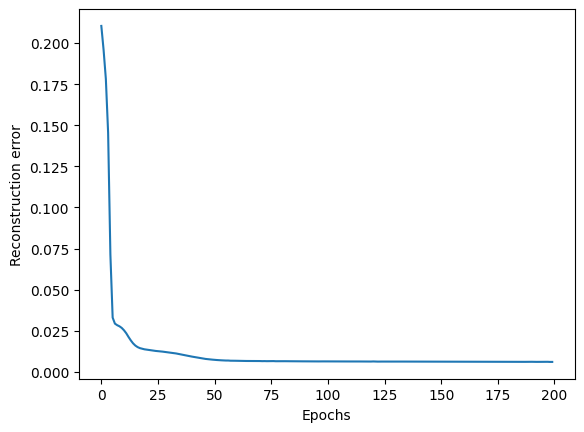

In [48]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

In [59]:
embeddings[:,:1].reshape(-1), embeddings[:,1:2].reshape(-1)

(array([ 1.6152087, 10.561468 ,  0.7884246, ...,  1.012466 ,  1.5196539,
         1.5024139], dtype=float32),
 array([2.1475837, 8.366171 , 1.5728819, ..., 1.7286143, 2.0811632,
        2.0691795], dtype=float32))

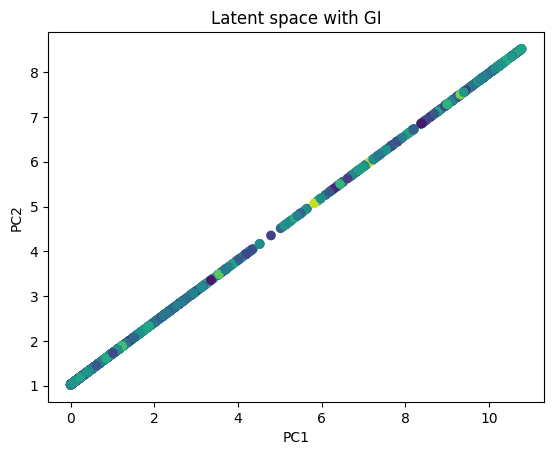

In [60]:
embeddings = autoencoder.encoder(torch.tensor(X.astype(np.float32)).to(device)).detach().cpu().numpy()
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(embeddings)

# X_embedded = TSNE(n_components=2, learning_rate='auto',
#                   init='random', perplexity=3).fit_transform(X)


plt.scatter(embeddings[:,:1].reshape(-1), embeddings[:,1:2].reshape(-1), c=foodData['GI'])#.apply(lambda x: 0 if x < median else 1))

plt.title("Latent space with GI")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [49]:
# set to evaluation mode
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for batch, labels in test_loader:

    with torch.no_grad():

        batch = batch.to(device)
        labels = labels.to(device)

        # autoencoder reconstruction
        batch_recon = autoencoder(batch, labels)

        # reconstruction error
        loss = F.mse_loss(batch_recon, batch)

        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

AttributeError: ignored

In [ ]:
embeddings = autoencoder.encoder(torch.tensor(X.astype(np.float32)).to(device)).detach().cpu().numpy()

In [ ]:
embeddings

array([[4.326855 , 1.4868499],
       [4.631447 , 1.6116593],
       [4.765673 , 1.6674423],
       ...,
       [4.4176927, 1.5221924],
       [4.5910926, 1.5939364],
       [4.5728292, 1.5864565]], dtype=float32)

In [ ]:
# torch.save(dict(zip(foodData['name'], embeddings), device='cpu'), "/content/drive/MyDrive/GI_Project/AEEmbeddingsByNameV4.pt")
torch.save(dict(zip(foodData['fdc_id'], embeddings), device='cpu'), "/content/drive/MyDrive/GI_Project/AEEmbeddingsByFdcIDV4.pt")

In [ ]:
embeddings = torch.load("/content/drive/MyDrive/GI_Project/AEEmbeddingsByFdcIDV1.pt")


In [ ]:
d = dict(zip(foodData['fdc_id'], embeddings))

In [ ]:
embeddings.detach().numpy()

array([[0.11618541, 0.46022266, 3.0225081 , ..., 1.8649411 , 0.859856  ,
        0.        ],
       [0.14324069, 0.47406107, 3.0308554 , ..., 1.8620849 , 0.8652352 ,
        0.        ],
       [1.7892461 , 1.5195633 , 3.0226855 , ..., 0.3476248 , 1.0931239 ,
        0.        ],
       ...,
       [0.8107623 , 0.3035833 , 1.8735745 , ..., 0.43227968, 0.01525207,
        0.41448876],
       [0.7875689 , 0.3560726 , 0.680261  , ..., 1.217722  , 0.        ,
        0.72806036],
       [1.3068522 , 1.4715043 , 0.47167546, ..., 0.7973403 , 0.704391  ,
        0.4763771 ]], dtype=float32)

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
# X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(embeddings.detach().numpy()[:1000])
X_embedded.shape